Total training samples: 106897
Batch Size 1: 106897 iterations per epoch
Batch Size 16: 6681 iterations per epoch
Batch Size 128: 835 iterations per epoch
Batch Size 1024: 104 iterations per epoch
Training with depth=1 and width=16
Epoch 0, Train Acc: 0.161, Val Acc: 0.223, Test Acc: 0.221
Epoch 1, Train Acc: 0.263, Val Acc: 0.329, Test Acc: 0.329
Epoch 2, Train Acc: 0.380, Val Acc: 0.417, Test Acc: 0.412
Epoch 3, Train Acc: 0.439, Val Acc: 0.466, Test Acc: 0.465
Epoch 4, Train Acc: 0.476, Val Acc: 0.497, Test Acc: 0.498
Epoch 5, Train Acc: 0.506, Val Acc: 0.527, Test Acc: 0.530
Epoch 6, Train Acc: 0.542, Val Acc: 0.564, Test Acc: 0.563
Epoch 7, Train Acc: 0.576, Val Acc: 0.591, Test Acc: 0.591
Epoch 8, Train Acc: 0.602, Val Acc: 0.619, Test Acc: 0.621
Epoch 9, Train Acc: 0.629, Val Acc: 0.645, Test Acc: 0.644
Epoch 10, Train Acc: 0.650, Val Acc: 0.670, Test Acc: 0.666
Epoch 11, Train Acc: 0.679, Val Acc: 0.702, Test Acc: 0.698
Epoch 12, Train Acc: 0.700, Val Acc: 0.730, Test Acc: 0.72

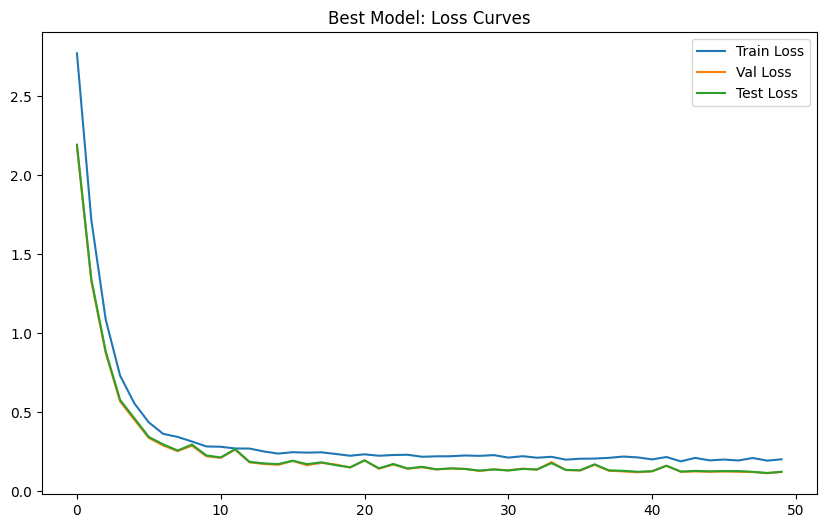

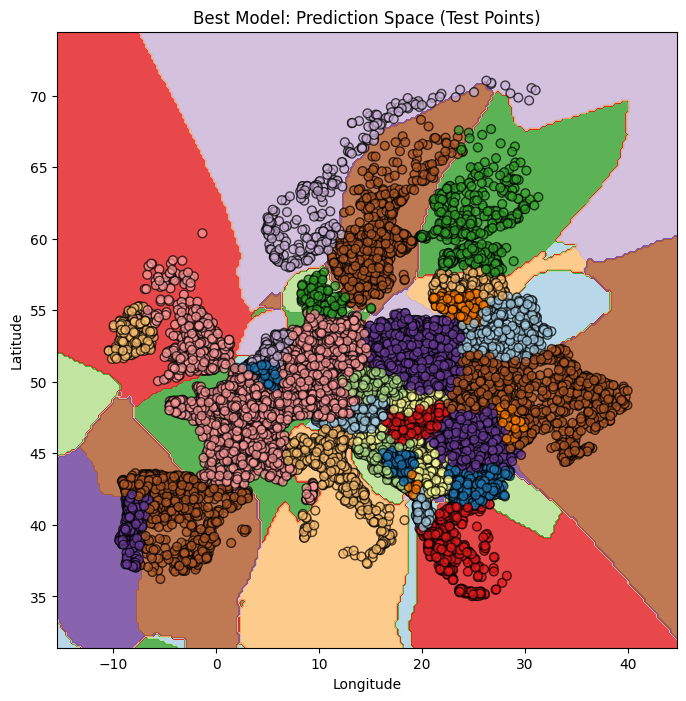

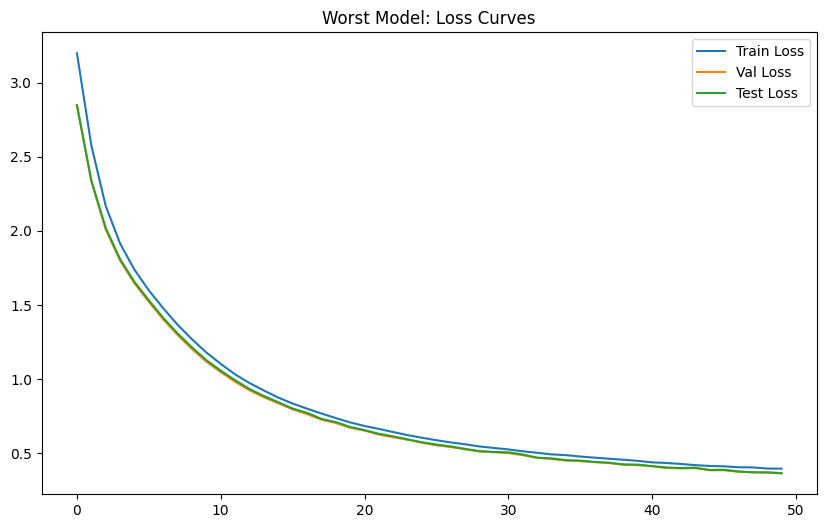

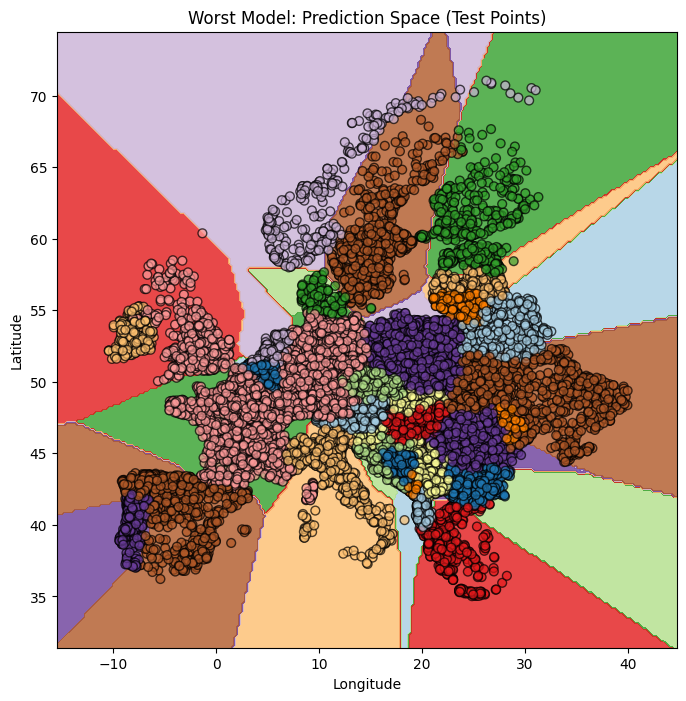

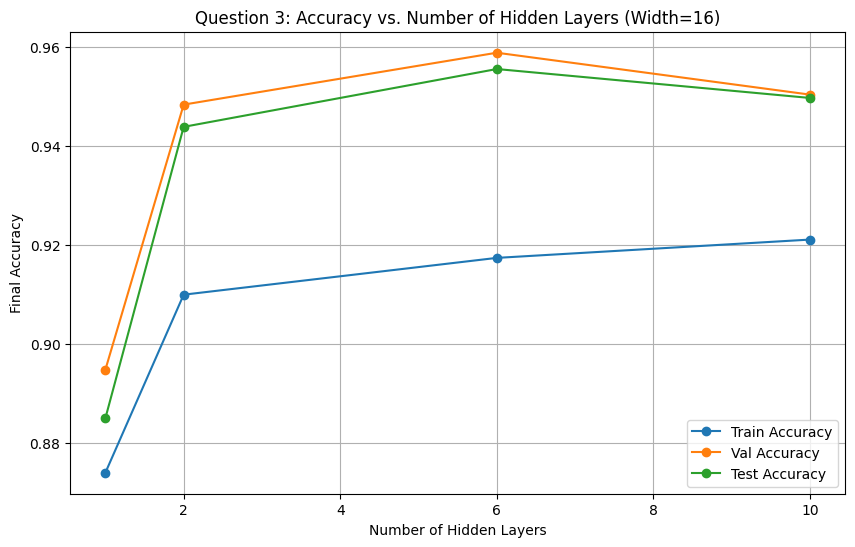

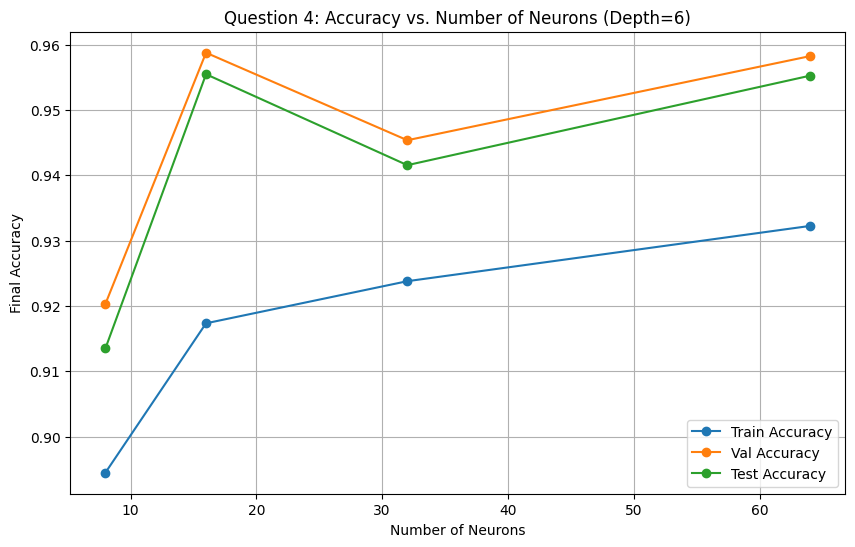

Monitoring Standard MLP Gradients...


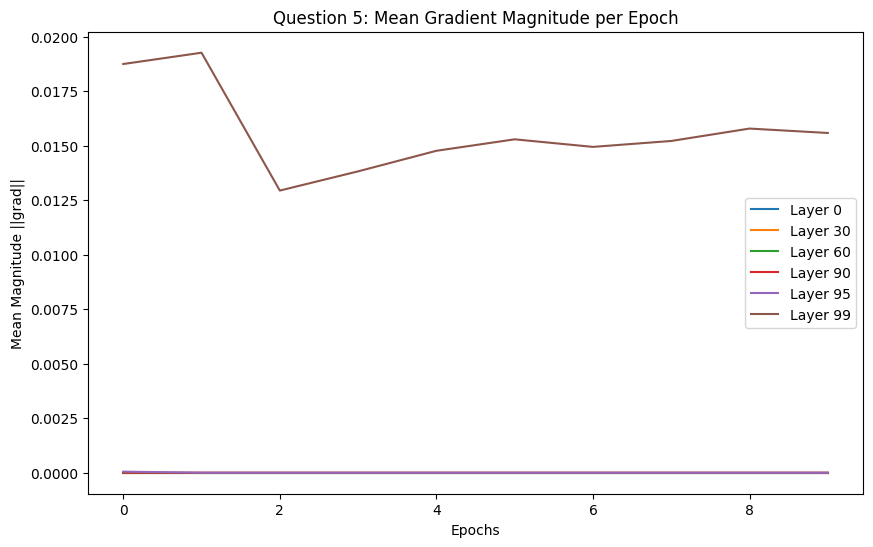

Monitoring Residual MLP Gradients...


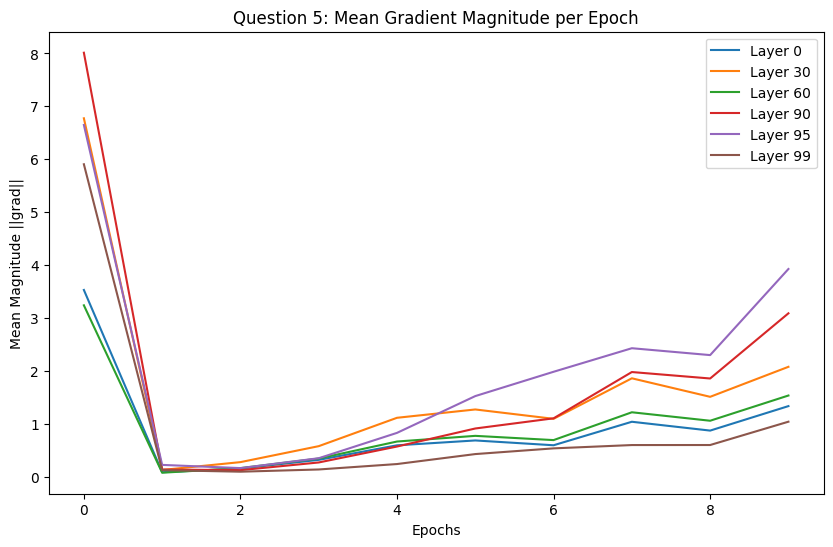


--- Training Implicit Representation Model ---
Epoch 0, Train Acc: 0.317, Val Acc: 0.511, Test Acc: 0.509
Epoch 1, Train Acc: 0.626, Val Acc: 0.744, Test Acc: 0.738
Epoch 2, Train Acc: 0.778, Val Acc: 0.816, Test Acc: 0.816
Epoch 3, Train Acc: 0.847, Val Acc: 0.900, Test Acc: 0.894
Epoch 4, Train Acc: 0.918, Val Acc: 0.940, Test Acc: 0.936
Epoch 5, Train Acc: 0.937, Val Acc: 0.946, Test Acc: 0.945
Epoch 6, Train Acc: 0.944, Val Acc: 0.956, Test Acc: 0.955
Epoch 7, Train Acc: 0.949, Val Acc: 0.963, Test Acc: 0.960
Epoch 8, Train Acc: 0.956, Val Acc: 0.966, Test Acc: 0.965
Epoch 9, Train Acc: 0.958, Val Acc: 0.969, Test Acc: 0.966
Epoch 10, Train Acc: 0.960, Val Acc: 0.972, Test Acc: 0.969
Epoch 11, Train Acc: 0.962, Val Acc: 0.970, Test Acc: 0.967
Epoch 12, Train Acc: 0.962, Val Acc: 0.970, Test Acc: 0.969
Epoch 13, Train Acc: 0.964, Val Acc: 0.969, Test Acc: 0.969
Epoch 14, Train Acc: 0.962, Val Acc: 0.970, Test Acc: 0.969
Epoch 15, Train Acc: 0.964, Val Acc: 0.972, Test Acc: 0.974
Ep

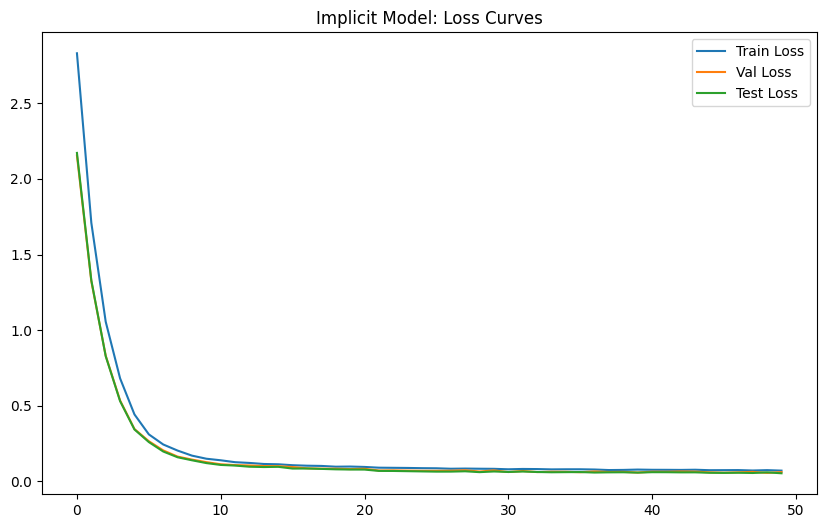

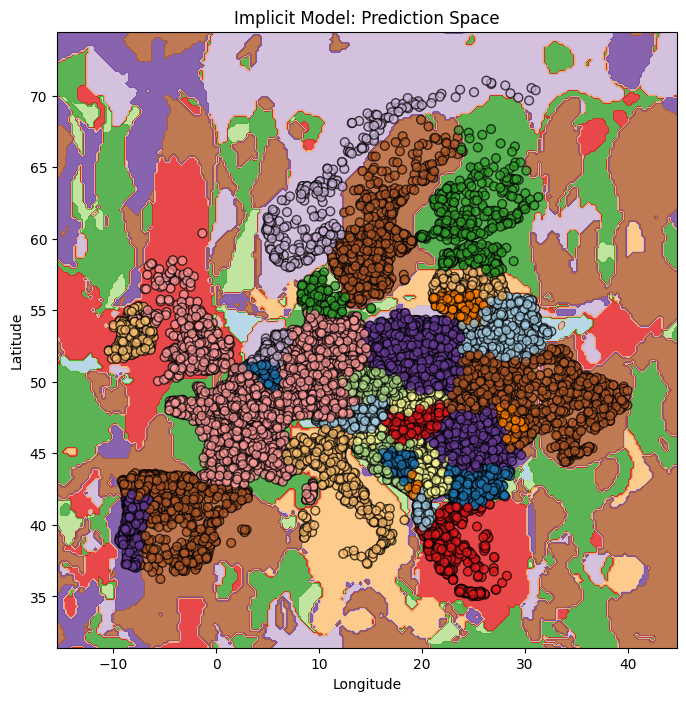

Standard Model Accuracy: 0.9588
Implicit Model Accuracy: 0.9793


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from helpers import *
import pandas as pd
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def set_seed(seed=42):
    """Sets the seed for reproducibility across numpy and torch (CPU/GPU)"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
class ResidualMLP(nn.Module):
    def __init__(self, num_hidden_layers, hidden_dim, output_dim, use_bn=True):
        super(ResidualMLP, self).__init__()
        self.use_bn = use_bn
        self.relu = nn.ReLU()

        # MOVE THESE INSIDE __init__
        self.input_layer = nn.Linear(2, hidden_dim)
        self.layers = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)])
        self.batch_norms = nn.ModuleList([nn.BatchNorm1d(hidden_dim) for _ in range(num_hidden_layers)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initial projection to hidden_dim
        x = self.relu(self.input_layer(x))

        for i in range(len(self.layers)):
            identity = x # Save for skip connection

            out = self.layers[i](x)
            if self.use_bn:
                out = self.batch_norms[i](out)

            # Apply residual addition before ReLU
            x = self.relu(out + identity)

        x = self.output_layer(x)
        return x

class EuropeDataset(Dataset):
    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
        """
        # Load the data into a tensor
        df = pd.read_csv(csv_file)
        # Extract the features (Longitude and Latitude), the type is f, the shape is (n,2)
        features = df[['long', 'lat']].values
        # Use the np array and create a tensor of float32
        self.features = torch.tensor(features, dtype=torch.float32)
        labels = df['country'].values
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.features)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the data row

        Returns:
            dictionary or list corresponding to a feature tensor and it's corresponding label tensor
        """
        # Return a tuple and not a dictionary for simplicity
        return self.features[idx], self.labels[idx]


class MLP(nn.Module):
    def __init__(self, num_hidden_layers, hidden_dim, output_dim, use_bn=False):
        super(MLP, self).__init__()
        self.use_bn = use_bn
        input_dim = 2
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        # First layer
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        # Remaining layers
        for _ in range(num_hidden_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))

        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            if self.use_bn:
                x = self.batch_norms[i](x)
            x = self.relu(x)
        x = self.output_layer(x)
        return x


def train(train_dataset, val_dataset, test_dataset, model, lr=0.001, epochs=50, batch_size=256):
    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True
    )
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False, num_workers=0)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_accs = []
    val_accs = []
    test_accs = []
    train_losses = []
    val_losses = []
    test_losses = []

    for ep in range(epochs):
        model.train()
        if batch_size == 1:
            model.eval()  # Forces BatchNorm to use ready stats instead
        run_loss, correct, total = 0, 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)  # Tracking processed samples
            correct += (predicted == labels).sum().item()

        # Add average loss per batch to the list of losses
        train_losses.append(run_loss / len(trainloader))
        train_accs.append(correct / total)

        # Evaluation on validation set
        model.eval()
        validation_loss, validation_correct, validation_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                validation_total += labels.size(0)
                validation_correct += (predicted == labels).sum().item()
        val_losses.append(validation_loss / len(valloader))
        val_accs.append(validation_correct / validation_total)

        with torch.no_grad():
            model.eval()
            test_loss, test_correct, test_total = 0, 0, 0
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_losses.append(test_loss / len(testloader))
        test_accs.append(test_correct / test_total)

        print('Epoch {:}, Train Acc: {:.3f}, Val Acc: {:.3f}, Test Acc: {:.3f}'.format(ep, train_accs[-1], val_accs[-1],
                                                                                       test_accs[-1]))

    return model, train_accs, val_accs, test_accs, train_losses, val_losses, test_losses


def plot_model_analysis(info, title_prefix):
    set_seed(42)
    plt.figure(figsize=(10, 6))
    plt.plot(info['train_losses'], label='Train Loss')
    plt.plot(info['val_losses'], label='Val Loss')
    plt.plot(info['test_losses'], label='Test Loss')
    plt.title(f"{title_prefix}: Loss Curves")
    plt.legend()
    plt.show()

    # Use the helper method to plot the boundaries
    plt.figure(figsize=(8, 8))
    plot_decision_boundaries(
        info['model'],
        test_dataset.features.numpy(),
        test_dataset.labels.numpy(),
        title=f"{title_prefix}: Prediction Space (Test Points)"
    )
    plt.show()


def plot_depth_network(results):
    set_seed(42)
    depths = []
    train_accs_final = []
    val_accs_final = []
    test_accs_final = []

    width_16_models = [result for result in results if result['config']['width'] == 16]

    # Sort by depth for plotting
    width_16_models.sort(key=lambda x: x['config']['depth'])

    for result in width_16_models:
        depths.append(result['config']['depth'])
        train_accs_final.append(result['train_acc'])
        val_accs_final.append(result['final_val_acc'])
        test_accs_final.append(result['test_accs'][-1])

    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_accs_final, marker='o', label='Train Accuracy')
    plt.plot(depths, val_accs_final, marker='o', label='Val Accuracy')
    plt.plot(depths, test_accs_final, marker='o', label='Test Accuracy')

    plt.title('Question 3: Accuracy vs. Number of Hidden Layers (Width=16)')
    plt.xlabel('Number of Hidden Layers')
    plt.ylabel('Final Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_width_network(results):
    set_seed(42)
    widths = []
    train_accs_final = []
    val_accs_final = []
    test_accs_final = []

    depth_6_models = [result for result in results if result['config']['depth'] == 6]

    # Sort by width for plotting
    depth_6_models.sort(key=lambda x: x['config']['width'])

    for result in depth_6_models:
        widths.append(result['config']['width'])
        train_accs_final.append(result['train_acc'])
        val_accs_final.append(result['final_val_acc'])
        test_accs_final.append(result['test_accs'][-1])

    plt.figure(figsize=(10, 6))
    plt.plot(widths, train_accs_final, marker='o', label='Train Accuracy')
    plt.plot(widths, val_accs_final, marker='o', label='Val Accuracy')
    plt.plot(widths, test_accs_final, marker='o', label='Test Accuracy')

    plt.title('Question 4: Accuracy vs. Number of Neurons (Depth=6)')
    plt.xlabel('Number of Neurons')
    plt.ylabel('Final Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


def monitor_gradients(output_dim, is_residual=False):
    set_seed(42)
    num_epochs = 10
    if(is_residual):
        model = ResidualMLP(num_hidden_layers=100, hidden_dim=4, output_dim=output_dim, use_bn=False).to(device)
    else:
        model = MLP(num_hidden_layers=100, hidden_dim=4, output_dim=output_dim, use_bn=False).to(device)  #
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
    target_layers = [0, 30, 60, 90, 95, 99]

    gradients = {i: [] for i in target_layers}

    for epoch in range(num_epochs):
        model.train()

        epoch_magnitudes = {i: 0.0 for i in target_layers}
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            #  Find the magnitude using the norm
            for i in target_layers:
                grad_norm = model.layers[i].weight.grad.norm().item()
                epoch_magnitudes[i] += grad_norm

            optimizer.step()

        for i in target_layers:
            avg_magnitude = epoch_magnitudes[i] / len(trainloader)
            gradients[i].append(avg_magnitude)
    plt.figure(figsize=(10, 6))


    for layer_idx, mags in gradients.items():
        plt.plot(mags, label=f'Layer {layer_idx}')

    plt.title('Question 5: Mean Gradient Magnitude per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Magnitude ||grad||')
    plt.legend()
    plt.show()

def get_implicit_representation(features):
    # We need exactly 10 steps from 0.1 to 1.0
    alphas = torch.linspace(0.1, 1.0, 10).to(features.device)
    transformed = torch.sin(features.unsqueeze(-1) * alphas)
    return transformed.view(features.shape[0], -1)


class ImplicitEuropeanDataset(EuropeDataset):
    def __getitem__(self, idx):
        features, labels = super().__getitem__(idx)
        implicit_features = get_implicit_representation(features.unsqueeze(0)).squeeze(0)
        return implicit_features, labels


def train_implicit_model(output_dim):
    set_seed(42)
    # Initialize the implicit dataset wrappers
    implicit_train_ds = ImplicitEuropeanDataset('train.csv')
    implicit_val_ds = ImplicitEuropeanDataset('validation.csv')
    implicit_test_ds = ImplicitEuropeanDataset('test.csv')

    # Setup the Model (Depth 6, Width 16)
    model = MLP(num_hidden_layers=6, hidden_dim=16, output_dim=output_dim, use_bn=True)
    model.layers[0] = nn.Linear(20, 16)
    model.to(device)

    # Train using your existing train function
    trained_model, t_accs, v_accs, test_accs, t_losses, v_losses, test_losses = train(
        implicit_train_ds, implicit_val_ds, implicit_test_ds,
        model, lr=0.001, epochs=50, batch_size=1024
    )

    return {
        'model': trained_model,
        'train_losses': t_losses,
        'val_losses': v_losses,
        'test_losses': test_losses,
        'final_val_acc': v_accs[-1],
        'test_dataset': implicit_test_ds
    }

def plot_implicit_analysis(info, title_prefix):
    set_seed(42)
    plt.figure(figsize=(10, 6))
    plt.plot(info['train_losses'], label='Train Loss')
    plt.plot(info['val_losses'], label='Val Loss')
    plt.plot(info['test_losses'], label='Test Loss')
    plt.title(f"{title_prefix}: Loss Curves")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 8))
    plot_decision_boundaries(
        info['model'],
        test_dataset.features.numpy(),
        test_dataset.labels.numpy(),
        title=f"{title_prefix}: Prediction Space",
        implicit_repr=True
    )
    plt.show()

if __name__ == '__main__':
    train_dataset = EuropeDataset('train.csv')
    val_dataset = EuropeDataset('validation.csv')
    test_dataset = EuropeDataset('test.csv')
    output_dim = len(torch.unique(train_dataset.labels))
    N = len(train_dataset)
    print(f"Total training samples: {N}")
    for bs in [1, 16, 128, 1024]:
        iterations = N // bs
        print(f"Batch Size {bs}: {iterations} iterations per epoch")
    """

    # --- QUESTION 6.1: Learning Rate Comparison ---
    learning_rates = [1.0, 0.01, 0.001, 0.00001]
    plt.figure(figsize=(10, 6))

    for lr in learning_rates:
        # Re-set seed inside the loop so every model starts with the exact same weights
        set_seed(42)
        model = MLP(6, 16, output_dim).to(device)

        _, _, _, _, _, v_losses, _ = train(
            train_dataset, val_dataset, test_dataset, model, lr=lr, epochs=50)

        plt.plot(v_losses, label=f'lr={lr}')

    plt.title('Question 1: Validation Loss for Different Learning Rates')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # --- QUESTION 6.2: Epoch Comparison ---
    set_seed(42)
    optimal_lr = 0.001
    model = MLP(6, 16, output_dim).to(device)

    model, train_accs, val_accs, test_accs, train_losses, val_losses, test_losses = train(
        train_dataset, val_dataset, test_dataset, model, lr=optimal_lr, epochs=100)

    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.plot(test_losses, label='Test Loss')

    plt.title('Question 2: Loss over 100 Epochs (Train, Val, Test) with Best Learning Rate' )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # --- QUESTION 6.3: Batch Norm Comparison ---

    bn_results = {}
    for use_bn in [True, False]:
      set_seed(42)
      label = "With BatchNorm" if use_bn else "Without BatchNorm"

      model = MLP(6,16, output_dim, use_bn=use_bn).to(device)

      _, _, v_accs, _, _, _, _ = train(
          train_dataset, val_dataset, test_dataset, model, lr=0.001, epochs=50)

      bn_results[label] = v_accs

    plt.figure(figsize=(10,6))
    for label, accs in bn_results.items():
      plt.plot(accs, label=label)
    plt.title('Question 3: Validation Accuracy Comparison')
    plt.legend()
    plt.show()


    # --- QUESTION 6.4: Batch Size Comparison ---
    batch_config = {
        1: 1,  # Batch Size 1: 1 Epoch
        16: 10,  # Batch Size 16: 10 Epochs
        128: 50,  # Batch Size 128: 50 Epochs
        1024: 50  # Batch Size 1024: 50 Epochs
    }

    val_acc_results = {}
    batch_loss_results = {}

    for bs, num_epochs in batch_config.items():
        set_seed(42)
        print(f"\n--- Training BS={bs} for {num_epochs} Epochs ---")

        model = MLP(6, 16, output_dim, use_bn=True).to(device)

        # For BS=1, use model.eval() as discussed to bypass the BN error
        model, _, v_accs, _, t_losses, _, _ = train(
            train_dataset, val_dataset, test_dataset, model,
            lr=0.001, epochs=num_epochs, batch_size=bs
        )

        val_acc_results[f'BS={bs}'] = v_accs
        batch_loss_results[f'BS={bs}'] = t_losses

    plt.figure(figsize=(10, 5))
    for label, accs in val_acc_results.items():
        plt.plot(accs, label=label)
    plt.title('Question 4(i): Validation Accuracy vs. Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    for label, losses in batch_loss_results.items():
        plt.plot(losses, label=label, alpha=0.7)
    plt.title('Question 4(iii): Training Loss vs. Batch (Stability)')
    plt.xlabel('Batch Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


"""

    configs = [
        {'depth': 1, 'width': 16},
        {'depth': 2, 'width': 16},
        {'depth': 6, 'width': 16},
        {'depth': 10, 'width': 16},
        {'depth': 6, 'width': 8},
        {'depth': 6, 'width': 32},
        {'depth': 6, 'width': 64},
    ]

    results = []
    for config in configs:
        depth, width = config['depth'], config['width']
        print(f"Training with depth={depth} and width={width}")

        set_seed(42)
        model = MLP(num_hidden_layers=depth, hidden_dim=width, output_dim=output_dim, use_bn=True).to(device)

        trained_model, t_accs, v_accs, test_accs, t_losses, v_losses, test_losses \
            = train(train_dataset, val_dataset, test_dataset, model, lr=0.001, epochs=50, batch_size=1024)

        results.append({
            'model': trained_model,
            'config': config,
            'train_acc': t_accs[-1],
            'final_val_acc': v_accs[-1],
            'train_losses': t_losses,
            'val_losses': v_losses,
            'test_losses': test_losses,
            'train_accs': t_accs,
            'val_accs': v_accs,
            'test_accs': test_accs
        })

    best_model_info = max(results, key=lambda x: x['final_val_acc'])
    worst_model_info = min(results, key=lambda x: x['final_val_acc'])

    print(
        f"\nBest Model: Depth {best_model_info['config']['depth']}, Width {best_model_info['config']['width']} (Val Acc: {best_model_info['final_val_acc']:.4f})")
    print(
        f"Worst Model: Depth {worst_model_info['config']['depth']}, Width {worst_model_info['config']['width']} (Val Acc: {worst_model_info['final_val_acc']:.4f})")

    plot_model_analysis(best_model_info, "Best Model")
    plot_model_analysis(worst_model_info, "Worst Model")
    plot_depth_network(results)
    plot_width_network(results)

    print("Monitoring Standard MLP Gradients...")
    monitor_gradients(output_dim, is_residual=False)

    # Monitor Residual MLP (will show healthy gradients)
    print("Monitoring Residual MLP Gradients...")
    monitor_gradients(output_dim, is_residual=True)


    print("\n--- Training Implicit Representation Model ---")
    implicit_results = train_implicit_model(output_dim)
    # Plot the results for the bonus question
    plot_implicit_analysis(implicit_results, "Implicit Model")

    # compare with results[2] which is Depth 6, Width 16 standard
    standard_6_16 = results[2]
    print(f"Standard Model Accuracy: {standard_6_16['final_val_acc']:.4f}")
    print(f"Implicit Model Accuracy: {implicit_results['final_val_acc']:.4f}")